In [1]:
import MDAnalysis as mda

/opt/miniconda3/envs/leiden/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import maicos

In [3]:
from intdielec.utils import *
from intdielec.utils.parallel import parallel_exec
from intdielec.watanalysis.dielectric import ParallelInverseDielectricConstant as PIDC

In [4]:
traj = "input_data/test.lammpstrj"
topo = "input_data/interface.psf"
u = mda.Universe(topo, 
                 traj, 
                 topology_format="PSF",
                 format="LAMMPSDUMP")

# My parallel code 

In [8]:
surf_ids = [[291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306],
            [371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386]]

task = PIDC(
        universe=u,
        bins=np.arange(0, 10, 0.2),
        axis="z",
        temperature=330,
        make_whole=False,
        surf_ids=surf_ids,
        c_ag="name O",
        select_all=True,
        )
parallel_exec(task.run, 0, 1000, 1, 20)

/opt/miniconda3/envs/leiden/lib/python3.9/multiprocessing/reduction.py:51: UserWarning: Reader has no dt information, set to 1.0 ps
  cls(buf, protocol).dump(obj)
/Users/jxzhu/workspace/software/mdanalysis/package/MDAnalysis/analysis/base.py:438: UserWarning: Reader has no dt information, set to 1.0 ps
  self.times[i] = ts.time


In [5]:
dname = "intdielec_out"
if not os.path.exists(dname):
    os.makedirs(dname)
np.save(os.path.join(dname, "inveps.npy"), task.results["inveps"])
np.save(os.path.join(dname, "M2.npy"), task.results["M2"])
np.save(os.path.join(dname, "m.npy"), task.results["m"])
np.save(os.path.join(dname, "mM.npy"), task.results["mM"])
np.save(os.path.join(dname, "M.npy"), task.results["M"])

# MAICoS

In [17]:
water = u.select_atoms('resname R1')
print(water)
# Create the analysis object with the appropriate parameters.
analysis_obj = maicos.DielectricPlanar(water, 
                                       bin_width=0.2, 
                                       refgroup=water, 
                                       is_3d=True, 
                                       unwrap=False, 
                                       temperature=330, 
                                       sym=True)
analysis_obj.run(start=0, stop=1000, step=1)

/Users/jxzhu/workspace/software/maicos/src/maicos/core/base.py:228: UserWarning: Reader has no dt information, set to 1.0 ps
  self.times[i] = ts.time
/Users/jxzhu/workspace/software/mdanalysis/package/MDAnalysis/core/groups.py:440: DeprecationWarning: The 'pbc' kwarg has been deprecated and will be removed in version 3.0., please use 'wrap' instead
  warnings.warn("The 'pbc' kwarg has been deprecated and will be "
Preparing error estimation.


<AtomGroup [<Atom 1: O of type O of resname R1, resid 1 and segid MOL1>, <Atom 2: H of type H of resname R1, resid 1 and segid MOL1>, <Atom 3: H of type H of resname R1, resid 1 and segid MOL1>, ..., <Atom 289: O of type O of resname R1, resid 97 and segid MOL1>, <Atom 290: H of type H of resname R1, resid 97 and segid MOL1>, <Atom 291: H of type H of resname R1, resid 97 and segid MOL1>]>


/Users/jxzhu/workspace/software/maicos/src/maicos/core/base.py:291: UserWarning: Your trajectory does not provide sufficient statistics to estimate a correlation time. Use the calculated error estimates with caution.
  self.corrtime = correlation_analysis(timeseries)


In [18]:
analysis_obj.save()

In [11]:
_y = analysis_obj.results.eps_perp.flatten()
y = (_y[:len(_y)//2] - np.flip(_y)[:len(_y)//2]) / 2

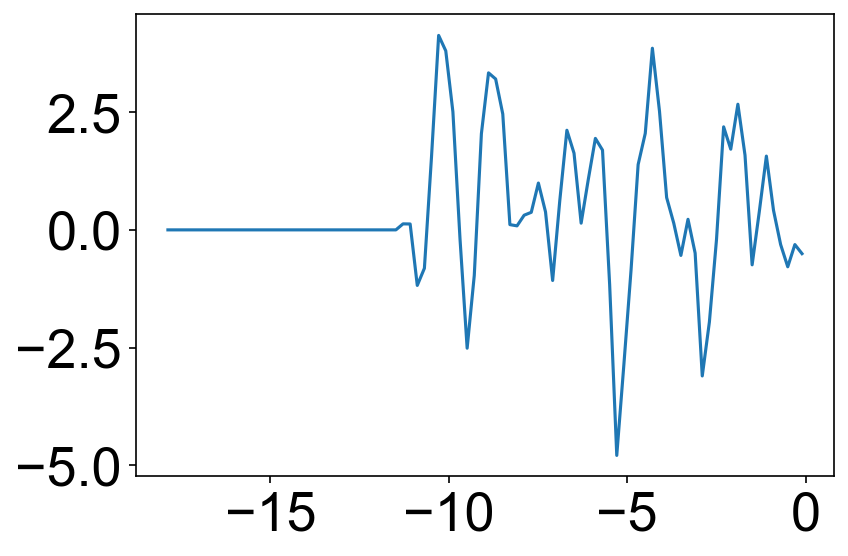

In [12]:
z = analysis_obj.results.bin_pos
plt.plot(z[:len(_y)//2], y)

plt.show()

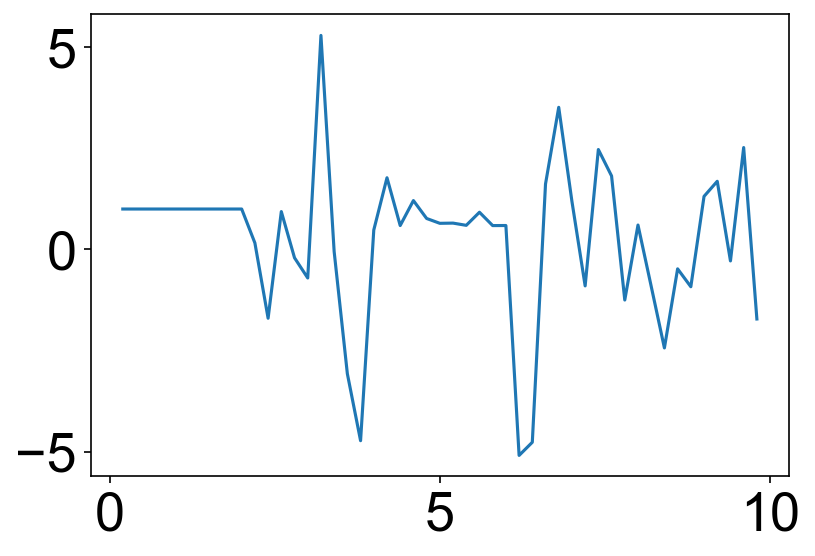

In [16]:
x = np.arange(0., 10., 0.2)
y = np.load("intdielec_out/inveps.npy")
plt.plot(x[1:], y)

plt.show()

/var/folders/w9/tf8znvhn5cj1fxnb4gkhy9zm0000gn/T/ipykernel_50184/1548683730.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


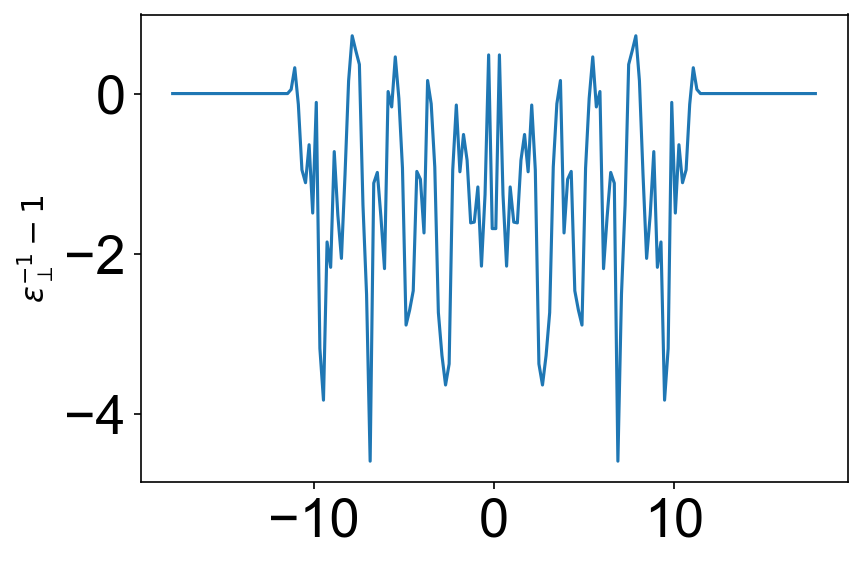

In [19]:
fig, ax = plt.subplots()

z = analysis_obj.results.bin_pos

ax.plot(z, analysis_obj.results.eps_perp)
ax.set_ylabel(r'$\varepsilon^{-1}_{\perp} - 1$')

# # Only plot the actual physical system:
# ax[0].set_xlim([-7, 7])
# ax[1].set_xlim([-7, 7])

# # Also plot the bulk values for reference
# ax[0].axhline(1 / 71 - 1, color='black', linestyle='dashed')
# ax[1].axhline(71 - 1, color='black', linestyle='dashed')

fig.tight_layout()
fig.show()

In [ ]:
# topo = "input_data/interface.psf"

fnames = glob.glob("**/dump.lammpstrj", recursive=True)
fnames.sort()

for fname in fnames:
    u = mda.Universe(topo, 
                     fname, 
                     topology_format="PSF",
                     format="LAMMPSDUMP")
    water = u.select_atoms('resname R1')
    # print(water)
    # Create the analysis object with the appropriate parameters.
    analysis_obj = maicos.DielectricPlanar(water, 
                                           bin_width=0.1, 
                                           refgroup=water, 
                                           is_3d=True, 
                                           unwrap=False, 
                                           temperature=330)
    analysis_obj.run(start=0, stop=1000, step=1)